In [2]:
import numpy as np
import nibabel
import nilearn
from nilearn.image import resample_to_img
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.plotting import show
from nilearn.plotting import plot_roi
from nilearn import image
from nilearn.masking import apply_mask
# get_ipython().magic('matplotlib inline')
import scipy
import matplotlib
import matplotlib.pyplot as plt
from nilearn import image
from nilearn.input_data import NiftiMasker
#from nilearn import plotting
import nibabel
from nilearn.masking import apply_mask
from nilearn.image import load_img
from nilearn.image import new_img_like
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, svm, metrics
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, LinearSVC
from sklearn.cross_validation import KFold
from sklearn.cross_validation import LeaveOneLabelOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_selection import SelectFwe
from scipy import signal
from scipy.fftpack import fft, fftshift
from scipy import interp
params = {'legend.fontsize': 'large',
          'figure.figsize': (5, 3),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
font = {'weight': 'bold',
        'size': 22}
plt.rc('font', **font)
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, f_classif, GenericUnivariateSelect, SelectKBest, chi2
from sklearn.feature_selection import RFE
import os
import seaborn as sns
sns.set_style("whitegrid")

import pandas as pd
import csv
from scipy import stats
import brainiak
import brainiak.funcalign.srm
import glob

In [3]:
projectDir='/jukebox/norman/amennen/prettymouth_fmriprep2/'
DMNmask='/jukebox/norman/amennen/MNI_things/Yeo_JNeurophysiol11_MNI152/Yeo_Network7mask_reoriented_resampledBOLD2.nii.gz'
fmriprep_dir=projectDir + '/derivatives/fmriprep'

In [4]:
# load subject numbers
subInd = 0
nsub=38
allnames = []
allgroups = []
groupInfo={}
performance_ST = {}
performance_TR = {}
# skip subjects 039 and 116
with open(projectDir + 'participants.tsv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        if 'sub' in row[0]:
            # now skip the subjects we don't want to analyze
            allInfo = row[0].split('\t')
            subjName=allInfo[0]
            if subjName != 'sub-039' and subjName != 'sub-116':
                if allInfo[3] == 'paranoia':
                    group = 0
                elif allInfo[3] == 'affair':
                    group = 1
                allnames.append(subjName)
                allgroups.append(group)
                subInd+=1

In [5]:
paranoidSubj = allnames[0:19]
cheatingSubj = allnames[19:]
paranoidLabel = allgroups[0:19]
cheatingLabel = allgroups[19:]
nfolds=19
print(allnames)
segment_score_vector = np.load('segment_score_vector.npy')
beliefs_vector = np.load('beliefs_vector.npy')
emotions_vector = np.load('emotions_vector.npy')
intentions_vector = np.load('intentions_vector.npy')

['sub-088', 'sub-089', 'sub-090', 'sub-091', 'sub-092', 'sub-093', 'sub-094', 'sub-095', 'sub-096', 'sub-097', 'sub-098', 'sub-099', 'sub-100', 'sub-101', 'sub-102', 'sub-103', 'sub-104', 'sub-105', 'sub-106', 'sub-107', 'sub-108', 'sub-109', 'sub-110', 'sub-111', 'sub-068', 'sub-081', 'sub-112', 'sub-053', 'sub-113', 'sub-031', 'sub-114', 'sub-115', 'sub-117', 'sub-118', 'sub-119', 'sub-120', 'sub-121', 'sub-122']


In [6]:
# load all the possible
n_options = 156
all_k1 = np.zeros((n_options))
all_k2 = np.zeros((n_options))
all_filters = np.zeros((n_options))
all_removeAvg = np.zeros((n_options))
all_masks = np.zeros((n_options))
with open('array_combinations_fmriprep2.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        #print(row)
        if line_count > 0:
            i=np.int(row[0])
            all_k1[i-1]=np.int(row[1])
            all_k2[i-1]=np.int(row[2])
            all_filters[i-1]=np.int(row[3])
            all_removeAvg[i-1]=np.int(row[4])
            all_masks[i-1]=np.int(row[5])
        line_count += 1

In [25]:
# now see how many have finished if exists, ploy
iterations_completed = []
classifierType = 2
lowhigh = 0
boostrapped = 1 # whether or not to randomly sample training data w/ replacement
for ii in np.arange(n_options):
    perm = ii + 1
    index = ii
    k1 = np.int(all_k1[index])
    k2 = np.int(all_k2[index])
    filterType = np.int(all_filters[index])
    ROI = np.int(all_masks[index])
    removeAvg = np.int(all_removeAvg[index])
    if not boostrapped:
        filename_data = 'new_bothphases/ARRAYDATA' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg) +  '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_' + str(perm) + '.npy'
    else:
        filename_data = 'new_bothphases/ARRAYDATA_BS_' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg) +  '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_' + str(perm) + '.npy'

    #print(filename_data)
    if os.path.isfile(filename_data):
        print('ITERATION %i FOUND' % perm)
        iterations_completed.append(ii)
        all_accuracies = np.load(filename_data) # this is 450 TRs x 1000 examples
    else:
        print('ITERATION %i NOT FOUND' % perm)
print('*************************************************')
print('ITERATIONS COMPLETED:')
print(iterations_completed)
n_completed = len(iterations_completed)
print('number completed: %i/%i' % (n_completed,n_options))

ITERATION 1 FOUND
ITERATION 2 FOUND
ITERATION 3 FOUND
ITERATION 4 FOUND
ITERATION 5 FOUND
ITERATION 6 FOUND
ITERATION 7 FOUND
ITERATION 8 FOUND
ITERATION 9 FOUND
ITERATION 10 FOUND
ITERATION 11 FOUND
ITERATION 12 FOUND
ITERATION 13 FOUND
ITERATION 14 FOUND
ITERATION 15 FOUND
ITERATION 16 FOUND
ITERATION 17 FOUND
ITERATION 18 FOUND
ITERATION 19 FOUND
ITERATION 20 FOUND
ITERATION 21 FOUND
ITERATION 22 FOUND
ITERATION 23 FOUND
ITERATION 24 FOUND
ITERATION 25 FOUND
ITERATION 26 FOUND
ITERATION 27 FOUND
ITERATION 28 FOUND
ITERATION 29 FOUND
ITERATION 30 FOUND
ITERATION 31 FOUND
ITERATION 32 FOUND
ITERATION 33 FOUND
ITERATION 34 FOUND
ITERATION 35 FOUND
ITERATION 36 FOUND
ITERATION 37 FOUND
ITERATION 38 FOUND
ITERATION 39 FOUND
ITERATION 40 FOUND
ITERATION 41 FOUND
ITERATION 42 FOUND
ITERATION 43 FOUND
ITERATION 44 FOUND
ITERATION 45 FOUND
ITERATION 46 FOUND
ITERATION 47 FOUND
ITERATION 48 FOUND
ITERATION 49 FOUND
ITERATION 50 FOUND
ITERATION 51 FOUND
ITERATION 52 FOUND
ITERATION 53 FOUND
IT

In [26]:
# now for the ones that have been completed:
# 1. average accuracy over 1000 samples
# 2. average accuracy over all TRs
# 3. plot
# 4. determine which one has the best one
n_completed = len(iterations_completed)
nTR = 450
n_iter = 1000
# build dictionaries to get averages for each classifier type completed and take average of both

if classifierType == 1:
    all_accuracy_data = np.zeros((nTR,n_iter,n_completed))
else:
    all_accuracy_data = np.zeros((n_iter,n_completed))
for cc in np.arange(n_completed):
    perm = iterations_completed[cc] + 1
    index = perm - 1
    k1 = np.int(all_k1[index])
    k2 = np.int(all_k2[index])
    filterType = np.int(all_filters[index])
    ROI = np.int(all_masks[index])
    removeAvg = np.int(all_removeAvg[index])
    if not boostrapped:
        filename_data = 'new_bothphases/ARRAYDATA' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg) +  '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_' + str(perm) + '.npy'
    else:
        filename_data = 'new_bothphases/ARRAYDATA_BS_' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg) +  '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_' + str(perm) + '.npy'
    all_accuracies = np.load(filename_data) # this is 450 TRs x 1000 examples
    if classifierType == 1:
        all_accuracy_data[:,:,cc] = all_accuracies
        performance_TR[index] = np.mean(all_accuracies)
    else:
        all_accuracy_data[:,cc] = all_accuracies
        performance_ST[index] = np.mean(all_accuracies)
# all_accuracy_data is 450 TRs x 1000 iterations x number of types completed

In [27]:
best_combination = np.zeros((n_options,))
for index in np.arange(n_options):
    if index in performance_TR.keys() and index in performance_ST.keys():
        best_combination[index] = (performance_TR[index] + performance_ST[index])/2

the best combo accuracy is 0.6318
*******************************
RANK 0
AVERAGE ACCURACY = 0.6318
mask
1.0
avg removed
1.0
filter
1.0
k1,k2
0.0
25.0
*******************************
RANK 1
AVERAGE ACCURACY = 0.6263
mask
0.0
avg removed
1.0
filter
1.0
k1,k2
0.0
25.0
*******************************
RANK 2
AVERAGE ACCURACY = 0.6263
mask
2.0
avg removed
0.0
filter
1.0
k1,k2
1.0
25.0
*******************************
RANK 3
AVERAGE ACCURACY = 0.6219
mask
2.0
avg removed
0.0
filter
1.0
k1,k2
0.0
25.0
*******************************
RANK 4
AVERAGE ACCURACY = 0.6193
mask
0.0
avg removed
0.0
filter
1.0
k1,k2
1.0
25.0
*******************************
RANK 5
AVERAGE ACCURACY = 0.6157
mask
2.0
avg removed
0.0
filter
1.0
k1,k2
1.0
50.0
*******************************
RANK 6
AVERAGE ACCURACY = 0.6141
mask
0.0
avg removed
0.0
filter
1.0
k1,k2
0.0
25.0
*******************************
RANK 7
AVERAGE ACCURACY = 0.6129
mask
0.0
avg removed
0.0
filter
1.0
k1,k2
0.0
50.0
*******************************
RANK 8

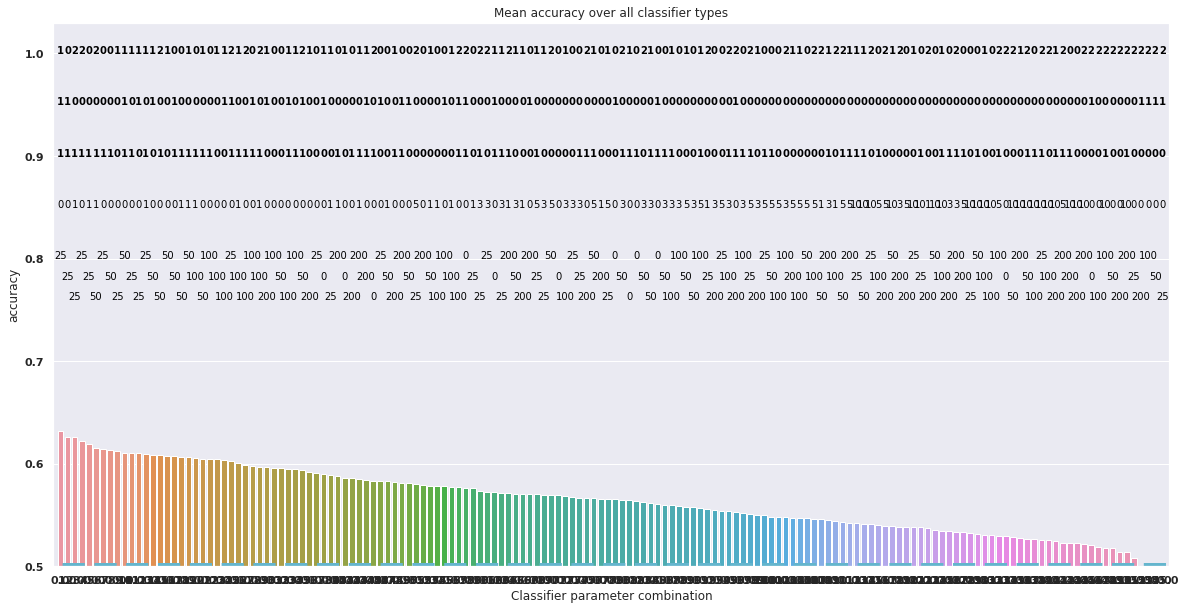

In [31]:

large_small_ind = np.argsort(best_combination)[::-1]
array_options = np.arange(n_options)
combo_sorted = best_combination[large_small_ind]
print('the best combo accuracy is %4.4f' % combo_sorted[0])
combo = np.arange(n_options)
all_data = np.concatenate((combo_sorted[:,np.newaxis],combo[:,np.newaxis]),axis=1)
df = pd.DataFrame(data=all_data,columns=['accuracy', 'combo'])

sns.set(font_scale=1)

plt.figure(figsize=(20,10))
#sns.set_style("whitegrid")

pl = sns.barplot(data=df,x="combo",y="accuracy",ci=95)
sns.set(font_scale=1)

#sns.stripplot(data=df,x="combo",y="accuracy",jitter=True,split=True,hue="datanull",color="k")
#sns.violinplot(data=df,x="combo",y="accuracy",hue="datanull",split=True)
for i in np.arange(n_options):
    perm = array_options[large_small_ind[i]] + 1
    c_index = perm - 1
    k1 = np.int(all_k1[c_index])
    k2 = np.int(all_k2[c_index])
    filterType = np.int(all_filters[c_index])
    wasAvgRemove = np.int(all_removeAvg[c_index])
    combo_k1k2 = [k1,k2]
    ROI = np.int(all_masks[c_index])
    str_avg = '%2.2f' % combo_sorted[i]
    shift = .05
    #pl.text(i, total_average_sorted[i]+0.1, str_avg, horizontalalignment='center', size='small', color='black', weight='light')
    pl.text(i, 1, str(ROI), horizontalalignment='center', size='small', color='black',weight='bold')
    pl.text(i, .95, str(wasAvgRemove), horizontalalignment='center', size='small', color='black',weight='bold')
    pl.text(i, 0.9 , str(filterType), horizontalalignment='center', size='small', color='black',weight='bold')
    pl.text(i, 0.85, str(k1), horizontalalignment='center', size='small', color='black',weight='light')
    if i % 3 == 0 :
        ytext = 0.8
    elif i % 3 == 1:
        ytext = 0.78
    elif i % 3 == 2:
        ytext = 0.76
    pl.text(i, ytext, str(k2), horizontalalignment='center', size='small', color='black',weight='light')

plt.plot([-10 ,n_options+5], [.5, .5], 'c--', lw=6)
plt.xlim([-1,n_options])
plt.ylim([0.5,1.03])
plt.xlabel('Classifier parameter combination')
plt.title('Mean accuracy over all classifier types')

#np.argwhere(iterations_completed == version)[0][0]
for ranking in np.arange(30):
    print('*******************************')
    print('RANK %i' % ranking )
    version = array_options[large_small_ind[ranking]]
    print('AVERAGE ACCURACY = %4.4f' % combo_sorted[ranking])
    print('mask')
    print(all_masks[version])
    print('avg removed')
    print(all_removeAvg[version])
    print('filter')
    print(all_filters[version])
    print('k1,k2')
    print(all_k1[version])
    print(all_k2[version])
    #print(all_k1[large_small_ind])

(0, 20)

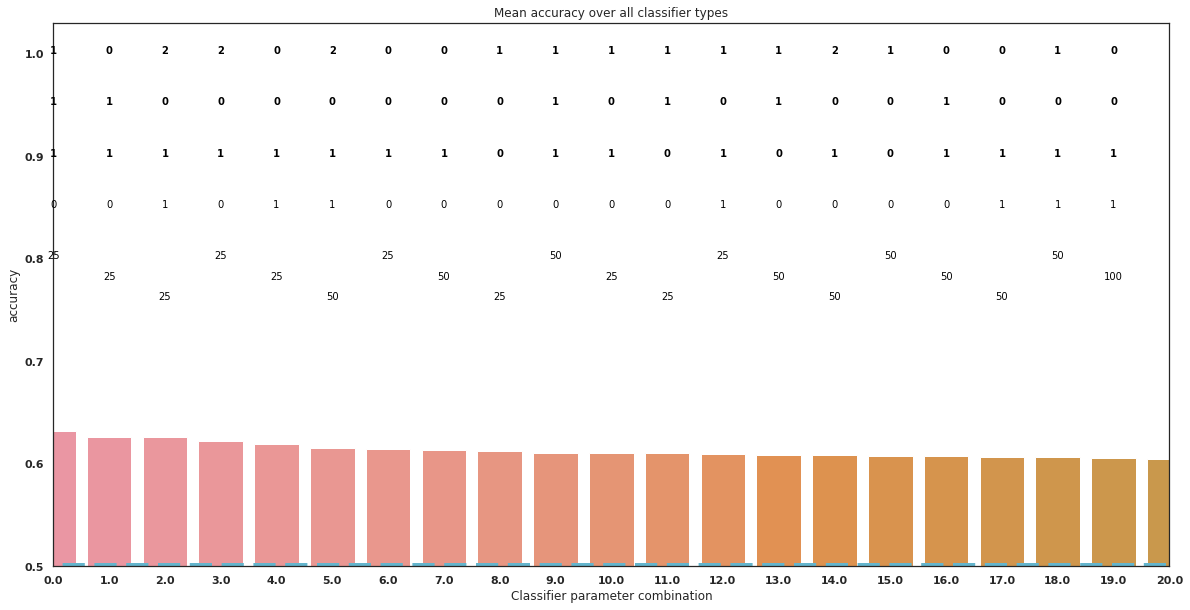

In [34]:
# FIGURE MADE FOR THESIS 1/13/20

plt.figure(figsize=(20,10))
sns.set_style("white")
# data frame controls everything
pl = sns.barplot(data=df,x="combo",y="accuracy",ci=95)
sns.set(font_scale=1)

#sns.stripplot(data=df,x="combo",y="accuracy",jitter=True,split=True,hue="datanull",color="k")
#sns.violinplot(data=df,x="combo",y="accuracy",hue="datanull",split=True)
# n_options=156 to show all
n_options_show=20
for i in np.arange(n_options_show):
    perm = array_options[large_small_ind[i]] + 1
    c_index = perm - 1
    k1 = np.int(all_k1[c_index])
    k2 = np.int(all_k2[c_index])
    filterType = np.int(all_filters[c_index])
    wasAvgRemove = np.int(all_removeAvg[c_index])
    combo_k1k2 = [k1,k2]
    ROI = np.int(all_masks[c_index])
    str_avg = '%2.2f' % combo_sorted[i]
    shift = .05
    #pl.text(i, total_average_sorted[i]+0.1, str_avg, horizontalalignment='center', size='small', color='black', weight='light')
    pl.text(i, 1, str(ROI), horizontalalignment='center', size='small', color='black',weight='bold')
    pl.text(i, .95, str(wasAvgRemove), horizontalalignment='center', size='small', color='black',weight='bold')
    pl.text(i, 0.9 , str(filterType), horizontalalignment='center', size='small', color='black',weight='bold')
    pl.text(i, 0.85, str(k1), horizontalalignment='center', size='small', color='black',weight='light')
    if i % 3 == 0 :
        ytext = 0.8
    elif i % 3 == 1:
        ytext = 0.78
    elif i % 3 == 2:
        ytext = 0.76
    pl.text(i, ytext, str(k2), horizontalalignment='center', size='small', color='black',weight='light')

plt.plot([-10 ,n_options+5], [.5, .5], 'c--', lw=6)
plt.ylim([0.5,1.03])
plt.xlabel('Classifier parameter combination')
plt.title('Mean accuracy over all classifier types')
plt.xlim([0,n_options_show])

In [33]:
n_options

156

In [75]:
# now plot
# there's 100 accuracy scores per each combo -- each accuracy score is an iteration of leave one out classification
# first take average over all 1000 iterations and for mean by TR
if classifierType == 1:
    TR_average = np.mean(all_accuracy_data,axis=1)
else:
    TR_average = all_accuracy_data # don't need to average anything
# now plot mean over all TRs in order from best to worst
total_average = np.mean(TR_average,axis=0)
large_small_ind = np.argsort(total_average)[::-1] # this is the indexes form all the ones that have been completed
TR_average_sorted = TR_average[:,large_small_ind]
total_average_sorted = total_average[large_small_ind]
print('the best classification accuracy is %4.4f' % total_average_sorted[0])

if classifierType ==1:
    data_acc_vector = TR_average_sorted.flatten()
    TR_number = np.repeat(np.arange(nTR),n_completed)
    combo = np.tile(np.arange(n_completed),nTR)
    all_data = np.concatenate((data_acc_vector[:,np.newaxis],TR_number[:,np.newaxis],combo[:,np.newaxis]),axis=1)
    df = pd.DataFrame(data=all_data, columns=['accuracy',  'TR', 'combo'])
else:
    accuracy_sorted = all_accuracy_data[:,large_small_ind]
    data_acc_vector = accuracy_sorted.flatten()
    combo = np.tile(np.arange(n_completed),n_iter)
    all_data = np.concatenate((data_acc_vector[:,np.newaxis],combo[:,np.newaxis]),axis=1)
    df = pd.DataFrame(data=all_data,columns=['accuracy', 'combo'])

the best classification accuracy is 0.5555


In [76]:
np.tile(np.array([0.8,0.77]),np.int(n_completed/2))

array([0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 ,
       0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77,
       0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 ,
       0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77,
       0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 ,
       0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77,
       0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 ,
       0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77,
       0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 ,
       0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77,
       0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 ,
       0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77,
       0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 ,
       0.77, 0.8 , 0.77, 0.8 , 0.77, 0.8 , 0.77, 0.

In [77]:
100  %2

0

Text(0.5,1,'Mean accuracy over all classifier types')

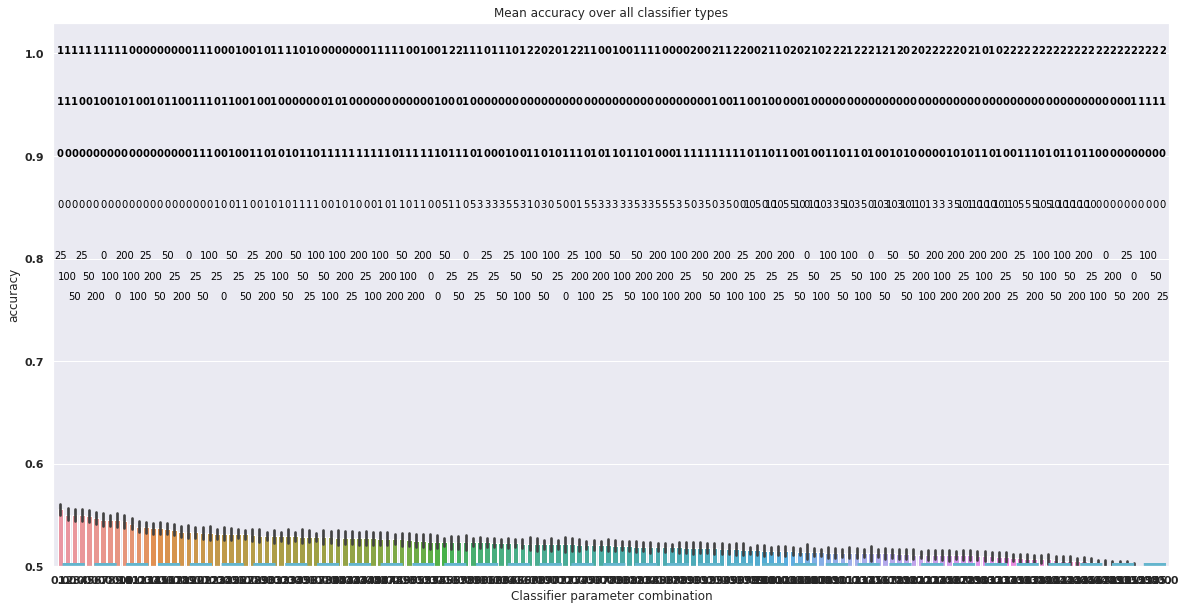

In [78]:
sns.set(font_scale=1)

plt.figure(figsize=(20,10))
pl = sns.barplot(data=df,x="combo",y="accuracy",ci=95)
#sns.stripplot(data=df,x="combo",y="accuracy",jitter=True,split=True,hue="datanull",color="k")
#sns.violinplot(data=df,x="combo",y="accuracy",hue="datanull",split=True)
for i in np.arange(n_completed):
    perm = iterations_completed[large_small_ind[i]] + 1
    c_index = perm - 1
    k1 = np.int(all_k1[c_index])
    k2 = np.int(all_k2[c_index])
    filterType = np.int(all_filters[c_index])
    wasAvgRemove = np.int(all_removeAvg[c_index])
    combo_k1k2 = [k1,k2]
    ROI = np.int(all_masks[c_index])
    str_avg = '%2.2f' % total_average_sorted[i]

    #pl.text(i, total_average_sorted[i]+0.1, str_avg, horizontalalignment='center', size='small', color='black', weight='light')
    pl.text(i, 1, str(ROI), horizontalalignment='center', size='small', color='black',weight='bold')
    pl.text(i, .95, str(wasAvgRemove), horizontalalignment='center', size='small', color='black',weight='bold')
    pl.text(i, 0.9 , str(filterType), horizontalalignment='center', size='small', color='black',weight='bold')
    pl.text(i, 0.85, str(k1), horizontalalignment='center', size='small', color='black',weight='light')
    if i % 3 == 0 :
        ytext = 0.8
    elif i % 3 == 1:
        ytext = 0.78
    elif i % 3 == 2:
        ytext = 0.76
    pl.text(i, ytext, str(k2), horizontalalignment='center', size='small', color='black',weight='light')

plt.plot([-10 ,n_completed+5], [.5, .5], 'c--', lw=6)
plt.xlim([-1,n_completed])
plt.ylim([0.5,1.03])
plt.xlabel('Classifier parameter combination')
plt.title('Mean accuracy over all classifier types')

In [79]:

#np.argwhere(iterations_completed == version)[0][0]
for ranking in np.arange(len(iterations_completed)):
    print('*******************************')
    print('RANK %i' % ranking )
    version = iterations_completed[large_small_ind[ranking]]
    print('AVERAGE ACCURACY = %4.4f' % total_average_sorted[ranking])
    print('mask')
    print(all_masks[version])
    print('avg removed')
    print(all_removeAvg[version])
    print('filter')
    print(all_filters[version])
    print('k1,k2')
    print(all_k1[version])
    print(all_k2[version])
    #print(all_k1[large_small_ind])

*******************************
RANK 0
AVERAGE ACCURACY = 0.5555
mask
1.0
avg removed
1.0
filter
0.0
k1,k2
0.0
25.0
*******************************
RANK 1
AVERAGE ACCURACY = 0.5504
mask
1.0
avg removed
1.0
filter
0.0
k1,k2
0.0
100.0
*******************************
RANK 2
AVERAGE ACCURACY = 0.5499
mask
1.0
avg removed
1.0
filter
0.0
k1,k2
0.0
50.0
*******************************
RANK 3
AVERAGE ACCURACY = 0.5497
mask
1.0
avg removed
0.0
filter
0.0
k1,k2
0.0
25.0
*******************************
RANK 4
AVERAGE ACCURACY = 0.5490
mask
1.0
avg removed
0.0
filter
0.0
k1,k2
0.0
50.0
*******************************
RANK 5
AVERAGE ACCURACY = 0.5473
mask
1.0
avg removed
1.0
filter
0.0
k1,k2
0.0
200.0
*******************************
RANK 6
AVERAGE ACCURACY = 0.5450
mask
1.0
avg removed
0.0
filter
0.0
k1,k2
0.0
0.0
*******************************
RANK 7
AVERAGE ACCURACY = 0.5450
mask
1.0
avg removed
0.0
filter
0.0
k1,k2
0.0
100.0
*******************************
RANK 8
AVERAGE ACCURACY = 0.5448
mask


(447,)
(1000, 447)


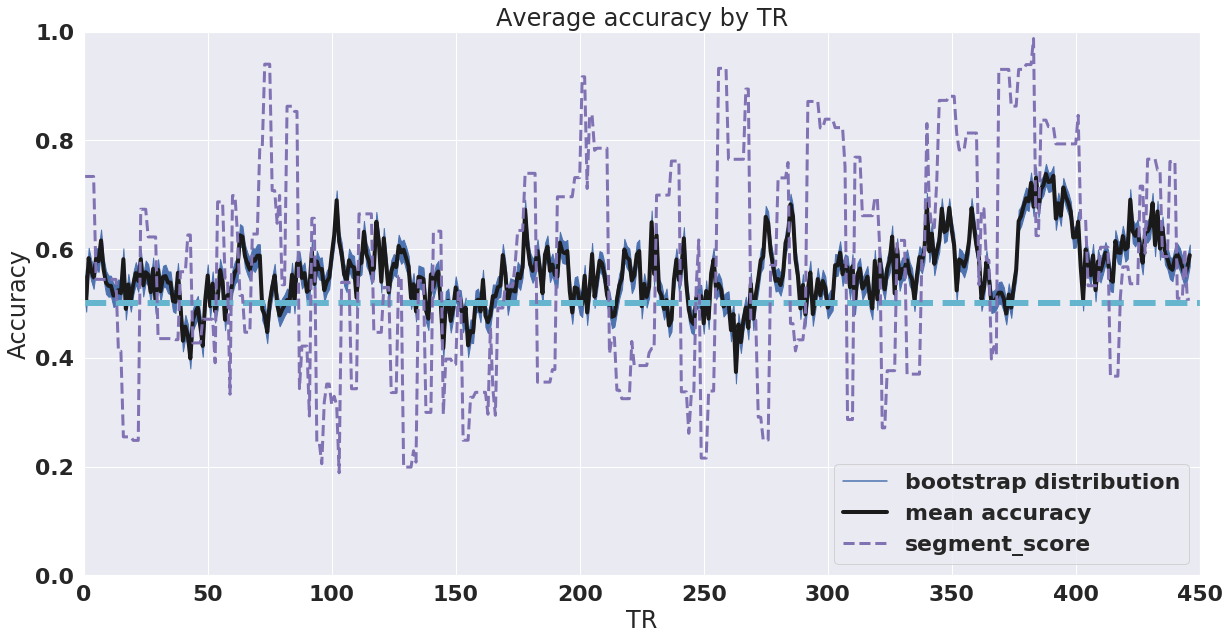

REAL correlation is 0.2106
REAL p value is 0.000007


Text(0.5,1,'Story difference vs. classification accuracy')

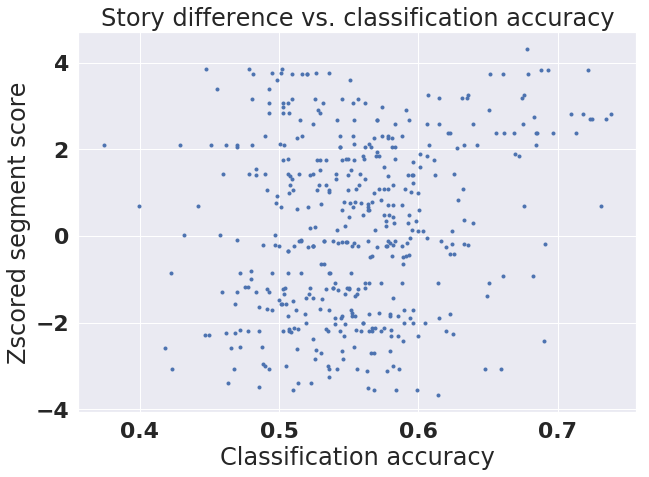

In [58]:
version = iterations_completed[large_small_ind[0]] # for top 1
index_in_matrix = np.argwhere(iterations_completed == version)[0][0]
accuracy = all_accuracy_data[:,:,index_in_matrix].T
x = np.arange(nTR-3)
y = accuracy[:,3:]
mean_acc = np.mean(y,axis=0)

print(np.shape(x))
print(np.shape(y))
# make into dataframe: TR, accuracy
n_iter=1000
TR_vec = np.tile(x,n_iter)
data = y.flatten()

iter_number = np.repeat(np.arange(n_iter),nTR-3)
matrix = np.concatenate((TR_vec[:,np.newaxis],data[:,np.newaxis],iter_number[:,np.newaxis]),axis=1)
df = pd.DataFrame(data=matrix, columns = ['TR', 'accuracy','iter'])

sns.set(style="white")
sns.set(font_scale=2)
err_band = {}
err_band['alpha'] = 1

plt.figure(figsize=(20,10))
sns.lineplot(x="TR",y="accuracy",color='b',data=df,ci=95,err_kws=err_band,label='bootstrap distribution')

plt.plot(x,np.mean(y,axis=0), color='k', lw=4, label='mean accuracy')
#plt.plot(x,np.mean(y,axis=0), color='k', label='accuracy')
plt.plot([0 ,500], [.5, .5], 'c--', lw=6)
plt.ylim([0,1])
plt.xlim([0,nTR])
plt.title('Average accuracy by TR')
plt.plot(segment_score_vector[0:-3]/10 + np.mean(y), '--', color='m', label='segment_score',linewidth=3)
plt.plot()
plt.legend(loc=4)
plt.ylabel('Accuracy')
plt.show()
[corr,p] = scipy.stats.pearsonr(mean_acc,segment_score_vector[0:-3])
print('REAL correlation is %4.4f' % corr)
print('REAL p value is %6.6f' % p)

plt.figure(figsize=(10,7))
plt.plot(mean_acc,segment_score_vector[0:-3], '.')
plt.xlabel('Classification accuracy')
plt.ylabel('Zscored segment score')
plt.title('Story difference vs. classification accuracy')

In [28]:
mean_acc[375:406]

array([0.6575, 0.6095, 0.716 , 0.759 , 0.7135, 0.7235, 0.6805, 0.774 ,
       0.6725, 0.787 , 0.7305, 0.764 , 0.755 , 0.7805, 0.77  , 0.7995,
       0.754 , 0.693 , 0.6905, 0.683 , 0.7495, 0.76  , 0.7345, 0.7865,
       0.635 , 0.632 , 0.7345, 0.5905, 0.5585, 0.684 , 0.5795])

In [29]:
np.mean(accuracy[:,378:409],axis=0)

array([0.6575, 0.6095, 0.716 , 0.759 , 0.7135, 0.7235, 0.6805, 0.774 ,
       0.6725, 0.787 , 0.7305, 0.764 , 0.755 , 0.7805, 0.77  , 0.7995,
       0.754 , 0.693 , 0.6905, 0.683 , 0.7495, 0.76  , 0.7345, 0.7865,
       0.635 , 0.632 , 0.7345, 0.5905, 0.5585, 0.684 , 0.5795])

In [33]:
np.mean(accuracy[:,380:402],axis=0)

array([0.716 , 0.759 , 0.7135, 0.7235, 0.6805, 0.774 , 0.6725, 0.787 ,
       0.7305, 0.764 , 0.755 , 0.7805, 0.77  , 0.7995, 0.754 , 0.693 ,
       0.6905, 0.683 , 0.7495, 0.76  , 0.7345, 0.7865])